In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from scipy.optimize import least_squares

## Good datasets maybe
## 
## Chemical regulation of body feather microbiota in a wild bird
## http://onlinelibrary.wiley.com/doi/10.1111/mec.14551/epdf
## https://datadryad.org//resource/doi:10.5061/dryad.k36t400
##
## Really good dataset
##
## Allometry and Ecology of the Bilaterian Gut Microbiome
## http://mbio.asm.org/content/9/2/e00319-18.full
## SRA: https://www.ncbi.nlm.nih.gov/Traces/study/?acc=SRP115877
## OTU Table: http://mbio.asm.org/content/9/2/e00319-18/DC3/embed/inline-supplementary-material-3.xlsx
## Code & other useful stuff: https://zenodo.org/record/1194331#.Wr_AHCMrLq4

## Useful NMF Docs and tutorials
## http://vazic.me/non-negative-matrix-factorization-nmf/
## http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/
## http://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf
## http://scikit-learn.org/stable/modules/decomposition.html#nmf

## Understanding sequencing data as compositions: an outlook and review
##     https://www.biorxiv.org/content/biorxiv/early/2017/10/19/206425.full.pdf
## The phylogenetic Kantorovich–Rubinstein metric for environmental sequence samples
##     uniFrac ~ Earth mover's distance
##     http://matsen.fhcrc.org/papers/evans2012phylogenetic.pdf
##     cited here: https://liorpachter.wordpress.com/2013/09/18/unifrac-revealed/

## More technical but still readable: https://arxiv.org/pdf/1401.5226v1.pdf
## generalized least squares objective function - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3673742/
## The Why and How of Nonnegative Matrix Factorization - https://arxiv.org/pdf/1401.5226v1.pdf

## Using Correlation Analysis and Nonnegative Matrix Factorization to Predict Protein 
## Structural Classes via Position–Specific Scoring Matrix
##     http://match.pmf.kg.ac.rs/electronic_versions/Match75/n3/match75n3_743-758.pdf

## Enterotypes
## Enterotypes in the landscape of gut microbial community composition
##     https://www.nature.com/articles/s41564-017-0072-8

#### Other things like this ####
## MixMC: http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0160169
## mixOmics: http://journals.plos.org/ploscompbiol/article?rev=2&id=10.1371/journal.pcbi.1005752
## KERNEL-PENALIZED REGRESSION FOR ANALYSIS OF MICROBIOME DATA - https://arxiv.org/pdf/1511.00297.pdf
## Latent Variable Modeling for the Microbiome - https://arxiv.org/pdf/1706.04969.pdf
##     They do usen an NMF for microbiome, but they do it weird. https://github.com/krisrs1128/microbiome_plvm
## gPCA - https://arxiv.org/pdf/1702.00501.pdf
##     Structured dimension reduction technique
## A multivariate zero-inflated logistic model for microbiome relative abundance data - https://arxiv.org/pdf/1709.07798.pdf
## * Phylogenetic factorization - https://peerj.com/articles/2969/?utm_source=TrendMD&utm_campaign=PeerJ_TrendMD_0&utm_medium=TrendMD
##     I don't exactly understand what they're doing, but it's phylogenetically informed, and they end up
##     with a barplot like thing, not sure if it's comparable.
## * PhILR - A phylogenetic transform enhances analysis of compositional microbiota data - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5328592/
##     Another from the Duke team. "the PhILR transform, which incorporates microbial evolutionary models with 
##     the isometric log-ratio transform to allow off-the-shelf statistical tools to be safely applied to microbiota surveys
##     It's actually not _much_ better than weighted unifrac
## sigtree: https://www.sciencedirect.com/science/article/pii/S2001037017300132
##     Not exactly the same idea, but still worth thinking about
## * ClaaTU - Ecophylogenetics Reveals the Evolutionary Associations between Mammals and their Gut Microbiota - https://www.biorxiv.org/content/biorxiv/early/2017/08/29/182212.full.pdf
##     James O'Dwyer does it again. Identifies importance of common ancestry and ecological redundancy.
## Edge PCA - Edge Principal Components and Squash Clustering: Using the Special Structure of Phylogenetic Placement Data for Sample Comparison
##     http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0056859
##     " Edge principal components analysis enables the detection of important differences between samples that 
##     contain closely related taxa. Each principal component axis is a collection of signed weights on the edges 
##     of the phylogenetic tree..."

In [2]:
## Generate fake count data
n = 10
length = 50
K = 2

## X is the data matrix
X = (np.random.lognormal(1, size=(n, length)) < 3).astype(int)
print(X)
Q = np.random.randint(2, size=(n, K))
G = np.random.randint(2, size=(K, length))
print(Q, G)

def freb_norm(G, kwargs=(X, Q)):
    return(np.linalg.norm(X - np.matmul(Q, G)))
print(freb_norm(G, kwargs=(X, Q)))

res_1 = least_squares(freb_norm, G, kwargs=(X, Q))

[[1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1
  0 1 0 0 0 0 1 1 0 1 0 0 1]
 [1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 0
  0 0 1 0 0 0 0 0 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1
  1 0 0 0 1 0 0 1 1 0 1 1 1]
 [1 0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1
  0 0 1 1 1 0 1 1 1 0 1 1 1]
 [0 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1
  0 1 1 0 1 0 0 0 0 0 0 1 0]
 [0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1 0
  1 1 1 0 1 1 1 0 0 0 1 1 0]
 [1 0 1 1 0 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 0
  1 1 1 0 1 0 0 0 1 0 1 1 0]
 [1 1 1 0 1 0 1 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0 0 1 0
  0 1 1 0 0 0 0 1 1 0 0 1 0]
 [1 1 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1
  0 0 1 1 1 1 0 0 0 1 1 1 0]
 [1 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0 1 0 1

ValueError: `x0` must have at most 1 dimension.

In [64]:
np.matmul(Q, G)
(X - np.matmul(Q, G))**2

array([[0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0],
       [1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 0,

In [7]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from scipy.optimize import least_squares

#X = (np.random.lognormal(1, size=(10, 50)))
model = NMF(alpha=0, n_components=3)
print(model)
W = model.fit_transform(X)
H = model.components_
#print(model.reconstruction_err_ )
#print(model.n_iter_)
print(H.shape)
print(W.shape)
#print(np.dot(W, H))
print(H)
print(W)

NMF(alpha=0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=3, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)
(3, 50)
(10, 3)
[[ 0.11056641  0.3862189   0.45540541  0.41009553  0.23263396  0.55090562
   0.31482058  0.          0.80637698  0.          0.54086818  0.45545302
   0.15855059  0.42731884  0.          0.0845011   0.3974226   0.
   0.37185392  0.41003749  0.42745722  0.          0.2223314   0.
   0.47376533  0.62755308  0.51001897  0.37059164  0.33417079  0.
   0.24472517  0.00270511  0.54568283  0.18563276  0.01616889  0.13557108
   0.47191126  0.25174253  0.          0.06180591  0.48126618  0.54086818
   0.75396987  0.57658351  0.35132423  0.50268576  0.02269349  0.45545302
   0.15855059  0.21845913]
 [ 0.42672524  0.22002603  0.55685704  0.07019712  0.56648907  0.
   0.17093715  0.29161484  0.          0.58935152  0.04819516  0.29486301
   0.51555363  0.4621792   0.16989167  0.2401115   0.51699126  0.72516159
   0.03655

In [18]:
def matrix_factorization(R, P, Q, K, steps=5000, alpha=0.0002, beta=0.02):
    Q = Q.T
    for step in xrange(steps):
        for i in xrange(len(R)):
            for j in xrange(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in xrange(K):
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eR = np.dot(P,Q)
        e = 0
        for i in xrange(len(R)):
            for j in xrange(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in xrange(K):
                        e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
        if e < 0.001:
            break
    return P, Q.T

In [31]:
if True:
    R = [
         [5,3,0,1],
         [4,0,0,1],
         [1,1,0,5],
         [1,0,0,4],
         [0,1,5,4],
        ]
    R = np.array(R)

    X = (np.random.lognormal(1, size=(n, length)) < 3).astype(int)
    R = X

    N = len(R)
    M = len(R[0])
    K = 3

    P = np.random.rand(N,K)
    Q = np.random.rand(M,K)

    nP, nQ = matrix_factorization(R, P, Q, K)
    
    print(nP)
    print(nQ)

[[0.66581757 0.69936514 0.50364604]
 [0.66512905 0.7115381  0.4956367 ]
 [0.63558801 0.71355811 0.50231296]]
[[0.14324382 0.98354113 0.39156021]
 [0.20087576 0.20118026 0.08131598]
 [0.74396637 0.22661815 0.6364062 ]
 [0.32145538 0.66048157 0.74921844]
 [0.8347145  0.72980318 0.90480007]
 [0.7653817  0.18381706 0.70774088]
 [0.85496155 0.19979899 0.59272528]
 [0.61796273 0.51983855 0.45142946]
 [0.79123003 0.59294441 0.11196736]
 [0.2216795  0.0391075  0.62246574]
 [0.76924054 0.24243887 0.55895723]
 [0.37456109 0.45888804 0.8404734 ]
 [0.59476298 0.45046336 0.58257514]
 [0.86760708 0.27857345 0.26591332]
 [0.22310607 0.75364855 0.61635821]
 [0.60567658 0.34037494 0.71800363]
 [0.89263148 0.55765902 0.01818588]
 [0.4337832  0.73373571 0.36805913]
 [0.32435074 0.66296776 0.61276497]
 [0.75275758 0.18240636 0.73943921]
 [0.38928665 0.55961477 0.54095707]
 [0.75928011 0.36205024 0.38146262]
 [0.30196545 0.76498791 0.84218479]
 [0.49945437 0.51059016 0.57910652]
 [0.33133202 0.44685188 0.9

In [9]:
print(X)
print(W/W.sum(axis=1, keepdims=True))

[[0 0 1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 0 1
  1 0 0 1 1 1 1 1 1 0 1 0 1]
 [1 0 1 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 1 0 1
  1 1 0 1 0 0 0 0 1 1 1 1 1]
 [0 0 1 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0 1 1 0 0 0
  0 0 0 0 1 1 1 0 1 1 1 1 1]
 [1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1
  1 0 1 1 1 1 1 0 1 0 1 1 0]
 [1 0 1 0 1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1
  0 1 0 1 1 0 0 1 0 1 0 1 1]
 [0 1 1 1 1 0 1 1 0 1 0 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1
  0 0 0 0 0 0 0 0 0 1 1 1 0]
 [1 0 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 1 1 1 0 1 1 1 0 1 0
  1 1 1 0 0 0 1 0 1 0 1 1 1]
 [1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1
  0 0 0 1 0 1 1 1 0 0 1 1 1]
 [1 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0
  0 1 0 0 0 1 0 0 1 0 1 1 1]
 [1 1 1 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 1

## Data from Gonzalez-Zapata et al (2018) "Holobiont Diversity in a Reef-Building Coral over Its Entire Depth Range in the Mesophotic Zone"

In [3]:
presabs = True
df = pd.read_csv("gimmeData.txt", header=0, delim_whitespace=True)
## Check if you need to clean the data
nan_rows = df[df["80m-SAI116"].isnull()]
## If nan_rows is empty that's a good thing
print(nan_rows)
## Just get the count data
dat = df.iloc[:, 8:]
if presabs:
    ## Just get presence/absence
    dat = (dat < 1).astype(int)


Empty DataFrame
Columns: [#OTU_ID, Kingdom, Phylum, Class, Order, Family, genus, species, 37m-SAI261, 38m-SAI265, 40m-SAI178, 45-SAI134, 60m-SAI237, 60m-SAI239, 65m-SAI244, 65m-SAI251, 65m-SAI229, 70m-SAI101, 75m-SAI211, 80m-SAI116]
Index: []


In [4]:
model = NMF(alpha=0, n_components=4, init="random")
X = dat.T
W = model.fit_transform(X)
H = model.components_
#print(model.reconstruction_err_ )
print(model.n_iter_)
print(H.shape)
print(W.shape)
#print(np.dot(W, H))
W/W.sum(axis=1, keepdims=True)


103
(4, 325)
(12, 4)


array([[ 0.6285897 ,  0.28284706,  0.08745614,  0.0011071 ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.81656342,  0.00141376,  0.18202282,  0.        ],
       [ 0.        ,  0.15780172,  0.49917928,  0.343019  ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.43480244,  0.28235622,  0.20354193,  0.07929941],
       [ 0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.53162828,  0.        ,  0.        ,  0.46837172],
       [ 0.52680235,  0.24049482,  0.17763808,  0.05506474],
       [ 0.25421385,  0.45186509,  0.01201567,  0.28190539],
       [ 0.10092923,  0.        ,  0.79425924,  0.10481152],
       [ 0.9590725 ,  0.        ,  0.00876287,  0.03216463]])

[[ 0.6285897   0.28284706  0.08745614  0.0011071 ]
 [ 0.          0.          1.          0.        ]
 [ 0.81656342  0.00141376  0.18202282  0.        ]
 [ 0.          0.15780172  0.49917928  0.343019  ]
 [ 0.          1.          0.          0.        ]
 [ 0.43480244  0.28235622  0.20354193  0.07929941]
 [ 0.          0.          0.          1.        ]
 [ 0.53162828  0.          0.          0.46837172]
 [ 0.52680235  0.24049482  0.17763808  0.05506474]
 [ 0.25421385  0.45186509  0.01201567  0.28190539]
 [ 0.10092923  0.          0.79425924  0.10481152]
 [ 0.9590725   0.          0.00876287  0.03216463]]


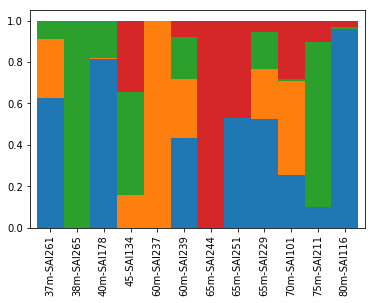

In [5]:
W2 = W/W.sum(axis=1, keepdims=True)
print(W2)
ind = np.arange(len(W2))
df_res = pd.DataFrame(W2, index=dat.columns)
ax = df_res.plot.bar(stacked=True, legend=False, width=1)
#ax.set_xticklabels(dat.columns, rotation=40)

# Data from human micribiome project

    http://downloads.hmpdacc.org/data/HMQCP/otu_table_psn_v35.txt.gz
    http://downloads.hmpdacc.org/data/HMQCP/v35_map_uniquebyPSN.txt.bz2
    
    Phyloseq tutorial where I found the links: http://joey711.github.io/phyloseq-demo/HMP_import_example.html,
    whoa you can actually get the sequence data too: http://downloads.hmpdacc.org/data/HMQCP/rep_set_v35.fna.gz

In [8]:
## READ the map file

df_hmp = pd.read_csv("v35_map_uniquebyPSN.txt", header=0, delim_whitespace=True, dtype=str)
print(df_hmp.head())
## Check if you need to clean the data (any nan in the last column)
nan_rows = df_hmp[df_hmp["Description"].isnull()]
## If nan_rows is empty that's a good thing
print(nan_rows)
## Just get the data we're interested in
df_map = df_hmp[["#SampleID", "sex", "HMPbodysubsite"]]
print(df_map.head())

stoolsamples = dfmap[dfmap["HMPbodysubsite"] == "Stool"]["#SampleID"]
print(len(stoolsamples))
salivasamples = dfmap[dfmap["HMPbodysubsite"] == "Saliva"]["#SampleID"]
print(len(salivasamples))
vagsamples = dfmap[dfmap["HMPbodysubsite"] == "Mid_vagina"]["#SampleID"]
print(len(vagsamples))



   #SampleID       RSID visitno     sex RUNCENTER HMPbodysubsite Mislabeled  \
0  700013549  158013734       1  female       BCM          Stool        NaN   
1  700014386  158398106       1    male    BCM,BI          Stool        NaN   
2  700014403  158398106       1    male    BCM,BI         Saliva        NaN   
3  700014409  158398106       1    male    BCM,BI  Tongue_dorsum        NaN   
4  700014412  158398106       1    male    BCM,BI    Hard_palate        NaN   

  Contaminated                                        Description  
0          NaN  HMP_Human_metagenome_sample_700013549_from_sub...  
1          NaN  HMP_Human_metagenome_sample_700014386_from_sub...  
2          NaN  HMP_Human_metagenome_sample_700014403_from_sub...  
3          NaN  HMP_Human_metagenome_sample_700014409_from_sub...  
4          NaN  HMP_Human_metagenome_sample_700014412_from_sub...  
Empty DataFrame
Columns: [#SampleID, RSID, visitno, sex, RUNCENTER, HMPbodysubsite, Mislabeled, Contaminated, Descrip

In [9]:
## READ a fraction of the data
nrows = 45400

dfhmpdat = pd.read_csv("otu_table_psn_v35.txt", header=0, delim_whitespace=True, nrows=nrows)
print(dfhmpdat.head(2))
## Check if you need to clean the data (any nan in the last column)
nan_rows = dfhmpdat[dfhmpdat["Consensus_Lineage"].isnull()]
## If nan_rows is empty that's a good thing
print(nan_rows)
bad_rows = dfhmpdat[dfhmpdat["Consensus_Lineage"] > 0]
print(bad_rows)



      #OTUID  700114607  700114380  700114716  700114798  700114710  \
0   OTU_97.1          0          0          0          0          0   
1  OTU_97.10          0          0          0          0          0   

   700114614  700114755  700114715  700114706  \
0          0          0          0          0   
1          0          0          0          1   

                         ...                          700032084  700032036  \
0                        ...                                  0          0   
1                        ...                                  0          0   

   700015970  700032180  700015873  700016708  700016812  700016713  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   

   700016048                                  Consensus_Lineage  
0          0  Root;p__Firmicutes;c__Bacilli;o__Lactobacillal...  
1          0  Root;p__Proteobacteria;c__Betaproteobacteri

In [10]:
presabs = True

## Ignore samples in the map that aren't in the OTU table
stools = dfhmpdat[np.intersect1d(dfhmpdat.columns, stoolsamples)]
salivs = dfhmpdat[np.intersect1d(dfhmpdat.columns, salivasamples)]
vags = dfhmpdat[np.intersect1d(dfhmpdat.columns, vagsamples)]
fulldat = pd.concat([stools, salivs, vags], axis=1)

if presabs:
    ## Just get presence/absence
    fulldat = (fulldat > 1).astype(int)

## How many samples are we looking at?
print(len(fulldat.iloc[0]))
model = NMF(alpha=0, n_components=3, init="random")
X = fulldat.T
W = model.fit_transform(X)
H = model.components_
#print(model.reconstruction_err_ )
print(model.n_iter_)
print(H.shape)
print(W.shape)
#print(np.dot(W, H))
#W/W.sum(axis=1, keepdims=True)


742
91
(3, 45383)
(742, 3)


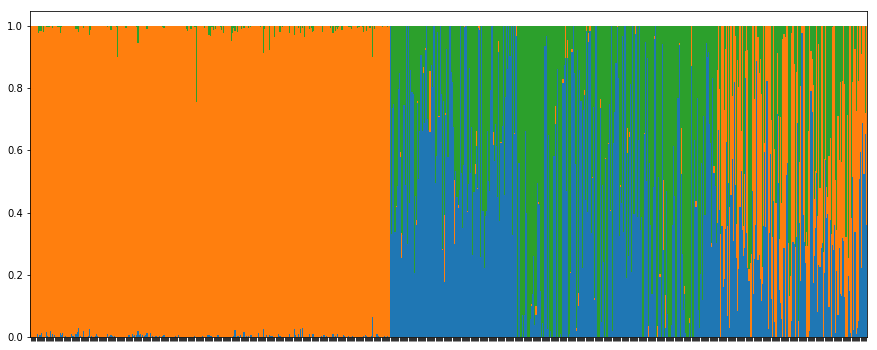

In [11]:
W2 = W/W.sum(axis=1, keepdims=True)
df_res = pd.DataFrame(W2)
ax = df_res.plot.bar(stacked=True, legend=False, width=1, figsize=(15, 6))
_ = ax.set_xticklabels([])

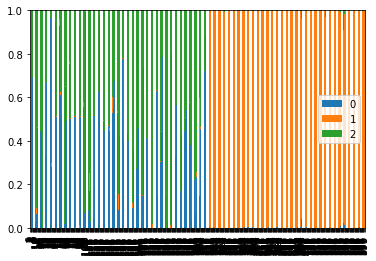

In [103]:
#print(W[:5]/W[:5].sum(axis=1, keepdims=True))
#print(W[:5])
#print(W[:5].sum(axis=1, keepdims=True))
num=600
tmp = W[:num]/W[:num].sum(axis=1, keepdims=True)
#print(tmp)
#print(tmp.sum(axis=1, keepdims=True))
pd.DataFrame(tmp).plot.bar(stacked=True)

199


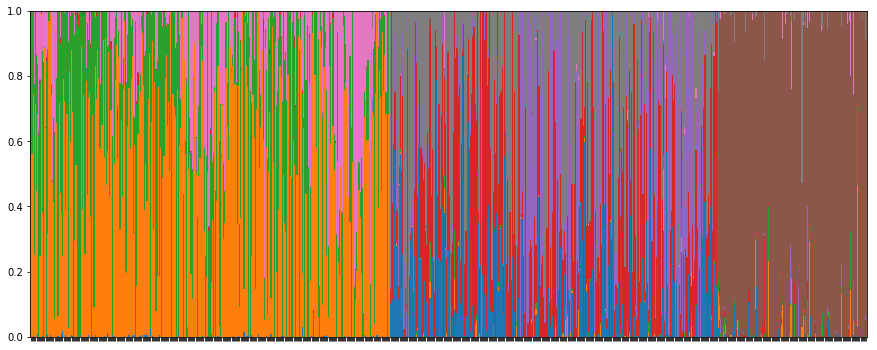

In [236]:
#dfmap.loc[dfmap["HMPbodysubsite"].isin(["Stool", "Saliva"])].sort_values("HMPbodysubsite")
presabs = True

alldfdat = dfmap.sort_values("HMPbodysubsite")
if presabs:
    ## Just get presence/absence
    alldfdat = (alldfdat > 1).astype(int)
fulldat[np.intersect1d(fulldat.columns, alldfdat["#SampleID"])]

model = NMF(alpha=0, n_components=8, init="random")
X = fulldat.T
W = model.fit_transform(X)
H = model.components_
print(model.n_iter_)
W2 = W/W.sum(axis=1, keepdims=True)
df_res = pd.DataFrame(W2)
ax = df_res.plot.bar(stacked=True, legend=False, width=1, figsize=(15, 6))
_ = ax.set_xticklabels([])

In [218]:
#fulldat[np.intersect1d(fulldat.columns, alldfdat["#SampleID"])]
print(sorted(list(set(alldfdat["HMPbodysubsite"]))))
print(alldfdat)

['Anterior_nares', 'Attached_Keratinized_gingiva', 'Buccal_mucosa', 'Hard_palate', 'Left_Antecubital_fossa', 'Left_Retroauricular_crease', 'Mid_vagina', 'Palatine_Tonsils', 'Posterior_fornix', 'Right_Antecubital_fossa', 'Right_Retroauricular_crease', 'Saliva', 'Stool', 'Subgingival_plaque', 'Supragingival_plaque', 'Throat', 'Tongue_dorsum', 'Vaginal_introitus']
      #SampleID     sex     HMPbodysubsite
1631  700037404    male     Anterior_nares
4694  700113499  female     Anterior_nares
1724  700038125    male     Anterior_nares
4011  700108614  female     Anterior_nares
308   700016313  female     Anterior_nares
1740  700038228    male     Anterior_nares
1751  700038343    male     Anterior_nares
1765  700038391    male     Anterior_nares
3993  700108548  female     Anterior_nares
3978  700108491    male     Anterior_nares
1801  700038498    male     Anterior_nares
294   700016234    male     Anterior_nares
1814  700038545    male     Anterior_nares
292   700016140  female     Anteri